In [4]:
# %% [code]
# ============================================================================
# COMPLETE CANADA DATA LOADER WITH SECTORAL ANALYSIS
# ============================================================================

import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

print("="*70)
print("CANADA ECONOMIC DATA LOADER WITH SECTORAL ANALYSIS")
print("="*70)

# Set data directory
DATA_DIR = "../data/raw"
print(f"Looking for data in: {DATA_DIR}")

# %% [code]
# 1. LOAD OIL DATA
print("\n" + "="*70)
print("1. LOADING OIL PRICE DATA")
print("="*70)

oil_path = os.path.join(DATA_DIR, "wti_crude_prices_2010_2024.csv")
if os.path.exists(oil_path):
    try:
        oil_data = pd.read_csv(oil_path)
        oil_data['date'] = pd.to_datetime(oil_data['date'])
        oil_data.set_index('date', inplace=True)
        print(f"✓ Oil data loaded: {len(oil_data)} rows")
        print(f"  Date range: {oil_data.index.min().date()} to {oil_data.index.max().date()}")
        print(f"  Price range: ${oil_data['price'].min():.2f} to ${oil_data['price'].max():.2f}")
    except Exception as e:
        print(f"✗ Error loading oil data: {e}")
        oil_data = None
else:
    print(f"✗ Oil data file not found: {oil_path}")
    oil_data = None

# %% [code]
# 2. LOAD AND PROCESS SECTORAL EMPLOYMENT DATA
print("\n" + "="*70)
print("2. LOADING SECTORAL EMPLOYMENT DATA")
print("="*70)

emp_sector_path = os.path.join(DATA_DIR, "canada_employment.csv")
if os.path.exists(emp_sector_path):
    try:
        # Read the sectoral employment data (skip first 6 rows of metadata)
        sector_emp_raw = pd.read_csv(emp_sector_path, encoding='utf-8', skiprows=6)
        
        print(f"✓ Sectoral employment data loaded: {len(sector_emp_raw)} rows, {len(sector_emp_raw.columns)} columns")
        
        # Find the industry column (first column with industry names)
        industry_col = sector_emp_raw.columns[0]
        
        # Get list of all industries (exclude total rows and metadata rows)
        all_industries = []
        industry_data = {}
        
        for idx, row in sector_emp_raw.iterrows():
            industry_name = str(row[industry_col]) if not pd.isna(row[industry_col]) else ""
            
            # Skip metadata rows and totals
            if not industry_name or any(x in industry_name for x in ['Geography', 'Type of employee', 'North American', 'Persons', 'Symbol legend']):
                continue
            
            # Skip footnote and citation rows
            if industry_name.startswith('Footnotes') or industry_name.startswith('How to cite'):
                continue
            
            # Process each industry's time series
            time_series = {}
            for col_name, value in row.items():
                # Skip industry name column and empty columns
                if col_name == industry_col or pd.isna(col_name):
                    continue
                
                # Parse date from column name (e.g., "January 2010")
                try:
                    # Clean column name
                    col_clean = str(col_name).strip()
                    if col_clean.startswith('"') and col_clean.endswith('"'):
                        col_clean = col_clean[1:-1]
                    
                    # Parse date
                    try:
                        date = pd.to_datetime(col_clean)
                    except:
                        # Try alternative format
                        date = pd.to_datetime(col_clean, format='%B %Y')
                    
                    # Clean employment value (remove quality flags A, B, C)
                    if not pd.isna(value):
                        val_str = str(value)
                        # Remove quality flags and commas
                        for flag in ['A', 'B', 'C', 'D', 'E', 'F']:
                            val_str = val_str.replace(flag, '')
                        val_str = val_str.replace(',', '').strip()
                        
                        if val_str and val_str != 'nan':
                            try:
                                time_series[date] = float(val_str)
                            except:
                                pass
                except Exception as e:
                    continue
            
            # Only add if we have time series data
            if time_series:
                all_industries.append(industry_name)
                industry_data[industry_name] = time_series
        
        # Convert to DataFrame
        sector_emp_df = pd.DataFrame(industry_data)
        sector_emp_df.index = pd.to_datetime(sector_emp_df.index)
        sector_emp_df = sector_emp_df.sort_index()
        
        # Select key sectors for analysis (you can modify this list)
        key_sectors = [
            "Mining, quarrying, and oil and gas extraction",
            "Construction", 
            "Manufacturing",
            "Transportation and warehousing",
            "Trade",  # Combined wholesale and retail
            "Finance and insurance",
            "Professional, scientific and technical services",
            "Health care and social assistance",
            "Accommodation and food services",
            "Goods producing industries",
            "Service producing industries"
        ]
        
        # Filter to key sectors
        available_sectors = [s for s in key_sectors if s in sector_emp_df.columns]
        sector_emp_df = sector_emp_df[available_sectors]
        
        print(f"✓ Processed {len(sector_emp_df.columns)} key sectors")
        print(f"  Available sectors: {list(sector_emp_df.columns)}")
        print(f"  Date range: {sector_emp_df.index.min().date()} to {sector_emp_df.index.max().date()}")
        print(f"  Data frequency: Monthly")
        
    except Exception as e:
        print(f"✗ Error loading sectoral employment data: {e}")
        import traceback
        traceback.print_exc()
        sector_emp_df = None
else:
    print(f"✗ Sectoral employment file not found")
    sector_emp_df = None

# %% [code]
# 3. LOAD GDP DATA
print("\n" + "="*70)
print("3. LOADING GDP DATA")
print("="*70)

gdp_path = os.path.join(DATA_DIR, "canada_gdp.csv")
if os.path.exists(gdp_path):
    try:
        # Read GDP data (skip first 6 rows)
        gdp_raw = pd.read_csv(gdp_path, encoding='utf-8', skiprows=6)
        
        print(f"✓ GDP data loaded: {len(gdp_raw)} rows, {len(gdp_raw.columns)} columns")
        
        # Find the industry column
        industry_col = gdp_raw.columns[0]
        
        # Extract time series for key sectors
        gdp_data = {}
        
        # Define sectors we want from GDP data
        gdp_sectors_of_interest = [
            "All industries  [T001]",
            "Mining, quarrying, and oil and gas extraction  [21]",
            "Manufacturing  [31-33]",
            "Construction  [23]",
            "Transportation and warehousing  [48-49]",
            "Energy sector  [T016]"
        ]
        
        for gdp_sector in gdp_sectors_of_interest:
            # Find the row for this sector
            sector_row = gdp_raw[gdp_raw[industry_col].str.contains(gdp_sector.split('[')[0].strip(), na=False)]
            
            if len(sector_row) > 0:
                row = sector_row.iloc[0]
                time_series = {}
                
                for col_name, value in row.items():
                    if col_name == industry_col or pd.isna(col_name):
                        continue
                    
                    # Parse quarter (e.g., "Q1 2010")
                    try:
                        col_clean = str(col_name).strip()
                        if col_clean.startswith('"') and col_clean.endswith('"'):
                            col_clean = col_clean[1:-1]
                        
                        if col_clean.startswith('Q'):
                            quarter, year = col_clean.split()
                            quarter_num = int(quarter[1])
                            month = (quarter_num - 1) * 3 + 1
                            date = pd.to_datetime(f"{year}-{month:02d}-01")
                            
                            if not pd.isna(value):
                                try:
                                    # Convert to float (remove commas if present)
                                    val_str = str(value).replace(',', '').strip()
                                    time_series[date] = float(val_str)
                                except:
                                    pass
                    except:
                        continue
                
                if time_series:
                    sector_name = gdp_sector.split('[')[0].strip()
                    gdp_data[sector_name] = time_series
        
        # Convert to DataFrame
        gdp_df = pd.DataFrame(gdp_data)
        gdp_df.index = pd.to_datetime(gdp_df.index)
        gdp_df = gdp_df.sort_index()
        
        print(f"✓ Processed GDP data for {len(gdp_df.columns)} sectors")
        print(f"  Available GDP sectors: {list(gdp_df.columns)}")
        print(f"  Date range: {gdp_df.index.min().date()} to {gdp_df.index.max().date()}")
        print(f"  Data frequency: Quarterly")
        
    except Exception as e:
        print(f"✗ Error loading GDP data: {e}")
        import traceback
        traceback.print_exc()
        gdp_df = None
else:
    print(f"✗ GDP file not found")
    gdp_df = None

# %% [code]
# 4. PREPARE DATA FOR CORRELATION ANALYSIS
print("\n" + "="*70)
print("4. PREPARING DATA FOR SECTORAL CORRELATION ANALYSIS")
print("="*70)

if oil_data is not None and sector_emp_df is not None:
    # Prepare oil price data (monthly average)
    oil_monthly = oil_data['price'].resample('M').mean()
    oil_returns = oil_monthly.pct_change() * 100  # Monthly percentage returns
    
    # Prepare sector employment growth (monthly)
    sector_growth = sector_emp_df.pct_change() * 100
    
    # Align dates
    common_dates = oil_returns.index.intersection(sector_growth.index)
    oil_aligned = oil_returns.loc[common_dates]
    sectors_aligned = sector_growth.loc[common_dates]
    
    print(f"✓ Aligned data for {len(common_dates)} months")
    print(f"  Common date range: {common_dates.min().date()} to {common_dates.max().date()}")
    
    # Function to calculate lagged correlations
    def calculate_sector_correlations(oil_series, sector_series, max_lag=6):
        results = {}
        
        for sector in sector_series.columns:
            sector_data = sector_series[sector].dropna()
            
            # Align dates for this specific sector
            sector_dates = sector_data.index.intersection(oil_series.index)
            if len(sector_dates) < 12:  # Need at least 1 year of data
                continue
                
            sector_aligned = sector_data.loc[sector_dates]
            oil_aligned_sector = oil_series.loc[sector_dates]
            
            # Calculate correlations at different lags
            lag_correlations = []
            for lag in range(max_lag + 1):
                if lag == 0:
                    corr = oil_aligned_sector.corr(sector_aligned)
                else:
                    corr = oil_aligned_sector.shift(lag).corr(sector_aligned)
                lag_correlations.append(corr)
            
            # Find peak correlation and optimal lag
            if lag_correlations:
                # Find absolute maximum correlation
                abs_correlations = [abs(c) if not pd.isna(c) else 0 for c in lag_correlations]
                peak_idx = np.argmax(abs_correlations)
                peak_corr = lag_correlations[peak_idx]
                
                results[sector] = {
                    'peak_correlation': peak_corr,
                    'peak_lag': peak_idx,
                    'corr_lag_0': lag_correlations[0],
                    'corr_lag_1': lag_correlations[1],
                    'corr_lag_2': lag_correlations[2],
                    'corr_lag_3': lag_correlations[3],
                    'data_points': len(sector_dates)
                }
        
        return results
    
    # Calculate correlations
    print("\nCalculating lagged correlations...")
    sector_results = calculate_sector_correlations(oil_aligned, sectors_aligned)
    
    # Create results DataFrame
    results_list = []
    for sector, metrics in sector_results.items():
        results_list.append({
            'Sector': sector,
            'Peak Correlation': metrics['peak_correlation'],
            'Optimal Lag (months)': metrics['peak_lag'],
            'Correlation (0-month lag)': metrics['corr_lag_0'],
            'Correlation (1-month lag)': metrics['corr_lag_1'],
            'Correlation (2-month lag)': metrics['corr_lag_2'],
            'Data Points': metrics['data_points']
        })
    
    results_df = pd.DataFrame(results_list)

CANADA ECONOMIC DATA LOADER WITH SECTORAL ANALYSIS
Looking for data in: ../data/raw

1. LOADING OIL PRICE DATA
✓ Oil data loaded: 3771 rows
  Date range: 2010-01-04 to 2024-12-30
  Price range: $-37.63 to $123.70

2. LOADING SECTORAL EMPLOYMENT DATA
✓ Sectoral employment data loaded: 47 rows, 1 columns
✓ Processed 0 key sectors
  Available sectors: []
  Date range: NaT to NaT
  Data frequency: Monthly

3. LOADING GDP DATA
✓ GDP data loaded: 47 rows, 1 columns
✓ Processed GDP data for 0 sectors
  Available GDP sectors: []
  Date range: NaT to NaT
  Data frequency: Quarterly

4. PREPARING DATA FOR SECTORAL CORRELATION ANALYSIS
✓ Aligned data for 0 months
  Common date range: NaT to NaT

Calculating lagged correlations...


C:\Users\explo\AppData\Local\Temp\ipykernel_102260\1149429017.py:250: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  oil_monthly = oil_data['price'].resample('M').mean()


In [5]:
# %% [code]
# ============================================================================
# FIXED EMPLOYMENT DATA LOADER - PROPERLY TRANSFORMED
# ============================================================================

import pandas as pd
import numpy as np
import os
from datetime import datetime

print("="*70)
print("FIXED EMPLOYMENT DATA LOADER")
print("="*70)

# Load the employment data correctly
emp_path = os.path.join("../data/raw", "canada_employment.csv")

# Read with skiprows=10 (this works based on debug)
emp_raw = pd.read_csv(emp_path, encoding='utf-8', skiprows=10)

print(f"Raw data shape: {emp_raw.shape}")
print(f"First column name: '{emp_raw.columns[0]}'")

# The data has industries as rows, dates as columns
# Column 0 = Industry names
# Columns 1+ = Monthly data (January 2010, February 2010, etc.)

# Clean the industry names column
industry_col = emp_raw.columns[0]
emp_raw[industry_col] = emp_raw[industry_col].astype(str)

# Remove the first row which is just "Persons"
emp_clean = emp_raw[~emp_raw[industry_col].str.contains('Persons', na=False)].copy()

print(f"\nAfter removing 'Persons' row: {emp_clean.shape}")

# Transpose the data: industries become columns, dates become rows
print("\nTransposing data...")

# Extract industry names (they will become our column names)
industry_names = emp_clean[industry_col].tolist()
print(f"Found {len(industry_names)} industries")
print(f"Sample industries: {industry_names[:5]}")

# Extract date columns (they will become our index)
date_columns = emp_clean.columns[1:]  # Skip the industry name column
print(f"Found {len(date_columns)} date columns")
print(f"First 5 dates: {date_columns[:5].tolist()}")

# Create a new DataFrame with dates as index
transposed_data = {}

for idx, industry in enumerate(industry_names):
    # Get the row for this industry
    industry_row = emp_clean.iloc[idx]
    
    # Create time series for this industry
    time_series = {}
    
    for date_col in date_columns:
        value = industry_row[date_col]
        
        # Skip NaN values
        if pd.isna(value):
            continue
            
        # Parse the date from column name
        try:
            # Column names are like "January 2010", "February 2010", etc.
            date_str = str(date_col).strip()
            if date_str.startswith('"') and date_str.endswith('"'):
                date_str = date_str[1:-1]
            
            # Parse the date (first day of month)
            date = pd.to_datetime(date_str)
            
            # Clean the value (remove commas and quality flags A, B, C)
            val_str = str(value)
            for flag in ['A', 'B', 'C', 'D', 'E', 'F']:
                val_str = val_str.replace(flag, '')
            val_str = val_str.replace(',', '').strip()
            
            if val_str and val_str != 'nan':
                try:
                    time_series[date] = float(val_str)
                except:
                    pass
                    
        except Exception as e:
            # Skip if we can't parse this date
            continue
    
    if time_series:  # Only add if we have data
        # Clean industry name (remove footnotes like "6 7 8")
        clean_industry = industry.split('  [')[0].split('  (')[0].strip()
        transposed_data[clean_industry] = time_series

# Create the transposed DataFrame
emp_df = pd.DataFrame(transposed_data)
emp_df.index = pd.to_datetime(emp_df.index)
emp_df = emp_df.sort_index()

print(f"\n✓ Successfully transposed data!")
print(f"Final shape: {emp_df.shape}")
print(f"Date range: {emp_df.index.min().date()} to {emp_df.index.max().date()}")
print(f"Industries: {list(emp_df.columns)}")

# Save for debugging
os.makedirs('../data/processed', exist_ok=True)
emp_df.to_csv('../data/processed/employment_by_industry_transposed.csv')
print(f"\n✅ Saved transposed data to: ../data/processed/employment_by_industry_transposed.csv")


FIXED EMPLOYMENT DATA LOADER
Raw data shape: (44, 181)
First column name: 'North American Industry Classification System (NAICS) 4'

After removing 'Persons' row: (44, 181)

Transposing data...
Found 44 industries
Sample industries: ['nan', 'Industrial aggregate including unclassified businesses 6 7 8', 'Industrial aggregate excluding unclassified businesses 6 7 8', 'Goods producing industries 9', 'Forestry, logging and support 10']
Found 180 date columns
First 5 dates: ['January 2010', 'February 2010', 'March 2010', 'April 2010', 'May 2010']

✓ Successfully transposed data!
Final shape: (180, 24)
Date range: 2010-01-01 to 2024-12-01
Industries: ['Industrial aggregate including unclassified businesses 6 7 8', 'Industrial aggregate excluding unclassified businesses 6 7 8', 'Goods producing industries 9', 'Forestry, logging and support 10', 'Mining, quarrying, and oil and gas extraction', 'Utilities', 'Construction', 'Manufacturing', 'Service producing industries 11', 'Trade 12', 'Transp

In [6]:
# %% [code]
# ============================================================================
# STEP 2: ALIGN WITH OIL DATA
# ============================================================================

print("\n" + "="*70)
print("ALIGNING WITH OIL DATA")
print("="*70)

# Load oil data
oil_path = os.path.join("../data/raw", "wti_crude_prices_2010_2024.csv")
oil_data = pd.read_csv(oil_path)
oil_data['date'] = pd.to_datetime(oil_data['date'])
oil_data.set_index('date', inplace=True)

print(f"Oil data: {oil_data.shape[0]} days, {oil_data.shape[1]} columns")
print(f"Oil date range: {oil_data.index.min().date()} to {oil_data.index.max().date()}")

# Convert oil to monthly (end of month)
oil_monthly = oil_data['price'].resample('ME').last()  # ME = Month End
oil_monthly.name = 'oil_price'

print(f"\nOil monthly: {len(oil_monthly)} months")
print(f"Oil monthly range: {oil_monthly.index.min().date()} to {oil_monthly.index.max().date()}")

# Align employment data index to month end (to match oil data)
emp_df_month_end = emp_df.copy()
emp_df_month_end.index = emp_df_month_end.index + pd.offsets.MonthEnd(0)

print(f"\nEmployment data: {emp_df_month_end.shape[0]} months, {emp_df_month_end.shape[1]} industries")
print(f"Employment range: {emp_df_month_end.index.min().date()} to {emp_df_month_end.index.max().date()}")

# Find common dates
common_dates = oil_monthly.index.intersection(emp_df_month_end.index)
print(f"\n✓ Common dates: {len(common_dates)} months")
print(f"  From: {common_dates.min().date()}")
print(f"  To: {common_dates.max().date()}")

if len(common_dates) > 0:
    # Align both datasets
    oil_aligned = oil_monthly.loc[common_dates]
    emp_aligned = emp_df_month_end.loc[common_dates]
    
    print(f"\nAligned datasets:")
    print(f"  - Oil prices: {len(oil_aligned)} months")
    print(f"  - Employment: {len(emp_aligned)} months, {emp_aligned.shape[1]} industries")
    
    # Calculate monthly growth rates
    oil_growth = oil_aligned.pct_change() * 100
    oil_growth.name = 'oil_growth'
    
    emp_growth = emp_aligned.pct_change() * 100
    
    print(f"\nGrowth rates calculated (first row removed due to NaN)")
    print(f"  - Oil growth: {len(oil_growth.dropna())} months")
    
    # Create a combined DataFrame for analysis
    combined_df = pd.DataFrame({
        'oil_price': oil_aligned,
        'oil_growth': oil_growth
    })
    
        # Add employment growth for ALL sectors
    all_sectors = [
        'Goods producing industries 9',
        'Forestry, logging and support 10',
        'Mining, quarrying, and oil and gas extraction',
        'Utilities',
        'Construction',
        'Manufacturing',
        'Service producing industries 11',
        'Trade 12',
        'Transportation and warehousing',
        'Information and cultural industries',
        'Finance and insurance',
        'Real estate and rental and leasing',
        'Professional, scientific and technical services',
        'Management of companies and enterprises',
        'Administrative and support, waste management and remediation services',
        'Educational services',
        'Health care and social assistance',
        'Arts, entertainment and recreation',
        'Accommodation and food services',
        'Other services (except public administration)',
        'Public administration',
        'Unclassified businesses 7'
    ]
    
    for sector in all_sectors:
        if sector in emp_growth.columns:
            combined_df[f'{sector}_growth'] = emp_growth[sector]
            print(f"  - Added: {sector}")
    
    # Remove first row (NaN due to pct_change)
    combined_clean = combined_df.iloc[1:].dropna()
    
    print(f"\n✅ Final aligned dataset: {combined_clean.shape[0]} months, {combined_clean.shape[1]} variables")
    print("\nFirst few rows:")
    print(combined_clean.head())
    
    # Save aligned data
    combined_clean.to_csv('../data/processed/aligned_oil_employment_growth.csv')
    print(f"\n✅ Saved aligned data to: ../data/processed/aligned_oil_employment_growth.csv")
    
else:
    print("✗ No common dates found! Check date ranges.")


ALIGNING WITH OIL DATA
Oil data: 3771 days, 1 columns
Oil date range: 2010-01-04 to 2024-12-30

Oil monthly: 180 months
Oil monthly range: 2010-01-31 to 2024-12-31

Employment data: 180 months, 24 industries
Employment range: 2010-01-31 to 2024-12-31

✓ Common dates: 180 months
  From: 2010-01-31
  To: 2024-12-31

Aligned datasets:
  - Oil prices: 180 months
  - Employment: 180 months, 24 industries

Growth rates calculated (first row removed due to NaN)
  - Oil growth: 179 months
  - Added: Goods producing industries 9
  - Added: Forestry, logging and support 10
  - Added: Mining, quarrying, and oil and gas extraction
  - Added: Utilities
  - Added: Construction
  - Added: Manufacturing
  - Added: Service producing industries 11
  - Added: Trade 12
  - Added: Transportation and warehousing
  - Added: Information and cultural industries
  - Added: Finance and insurance
  - Added: Real estate and rental and leasing
  - Added: Professional, scientific and technical services
  - Added: M

In [8]:
# %% [code]
# ============================================================================
# STEP 3: FULL SECTOR CORRELATION ANALYSIS
# ============================================================================

if 'combined_clean' in locals() and len(combined_clean) > 0:
    print("\n" + "="*70)
    print("FULL SECTOR CORRELATION ANALYSIS")
    print("="*70)
    
    # Check correlations with oil growth
    oil_growth_col = combined_clean['oil_growth']
    
    correlations = []
    all_sectors = [
        'Goods producing industries 9',
        'Forestry, logging and support 10',
        'Mining, quarrying, and oil and gas extraction',
        'Utilities',
        'Construction',
        'Manufacturing',
        'Service producing industries 11',
        'Trade 12',
        'Transportation and warehousing',
        'Information and cultural industries',
        'Finance and insurance',
        'Real estate and rental and leasing',
        'Professional, scientific and technical services',
        'Management of companies and enterprises',
        'Administrative and support, waste management and remediation services',
        'Educational services',
        'Health care and social assistance',
        'Arts, entertainment and recreation',
        'Accommodation and food services',
        'Other services (except public administration)',
        'Public administration',
    ]
    
    for sector in all_sectors:
        sector_growth_col = f"{sector}_growth"
        
        if sector_growth_col in combined_clean.columns:
            sector_growth = combined_clean[sector_growth_col]
            
            # Calculate correlations at different lags (0-3 months)
            corr_0 = oil_growth_col.corr(sector_growth)
            corr_1 = oil_growth_col.shift(1).corr(sector_growth)
            corr_2 = oil_growth_col.shift(2).corr(sector_growth)
            corr_3 = oil_growth_col.shift(3).corr(sector_growth)
            
            # Find best lag
            corrs = [corr_0, corr_1, corr_2, corr_3]
            best_lag = np.argmax([abs(c) if not pd.isna(c) else -1 for c in corrs])
            best_corr = corrs[best_lag]
            
            correlations.append({
                'Sector': sector,
                'Correlation (0-month)': corr_0,
                'Correlation (1-month)': corr_1,
                'Correlation (2-month)': corr_2,
                'Correlation (3-month)': corr_3,
                'Best Lag': best_lag,
                'Best Correlation': best_corr
            })
    
    # Create results DataFrame
    results_df = pd.DataFrame(correlations)
    results_df['Abs Correlation'] = results_df['Best Correlation'].abs()
    results_df = results_df.sort_values('Abs Correlation', ascending=False)
    
    print("\n📊 FULL SECTOR SENSITIVITY TO OIL PRICES (Growth Rates):")
    print(results_df[['Sector', 'Best Correlation', 'Best Lag']].to_string(index=False))
    
    # Create short names for better display
    sector_name_shortener = {
        "Goods producing industries 9": "Goods Producing",
        "Forestry, logging and support 10": "Forestry & Logging",
        "Mining, quarrying, and oil and gas extraction": "Mining & Oil/Gas",
        "Service producing industries 11": "Service Producing",
        "Trade 12": "Trade",
        "Transportation and warehousing": "Transportation",
        "Information and cultural industries": "Information & Cultural",
        "Finance and insurance": "Finance & Insurance",
        "Real estate and rental and leasing": "Real Estate",
        "Professional, scientific and technical services": "Professional Services",
        "Management of companies and enterprises": "Management",
        "Administrative and support, waste management and remediation services": "Admin & Support",
        "Educational services": "Education",
        "Health care and social assistance": "Healthcare",
        "Arts, entertainment and recreation": "Arts & Entertainment",
        "Accommodation and food services": "Accommodation & Food",
        "Other services (except public administration)": "Other Services",
        "Public administration": "Public Admin",
    }
    
    results_df['Sector_Short'] = results_df['Sector'].map(lambda x: sector_name_shortener.get(x, x[:30]))
    
    print("\n📊 TOP 10 MOST SENSITIVE SECTORS:")
    top_10 = results_df.head(10)
    print(top_10[['Sector_Short', 'Best Correlation', 'Best Lag']].to_string(index=False))
    
    print("\n📊 TOP 10 LEAST SENSITIVE SECTORS:")
    bottom_10 = results_df.tail(10)
    print(bottom_10[['Sector_Short', 'Best Correlation', 'Best Lag']].to_string(index=False))
    
    # Save results
    results_df.to_csv('../data/processed/full_sector_correlations.csv', index=False)
    print(f"\n✅ Saved full correlation results to: ../data/processed/full_sector_correlations.csv")


FULL SECTOR CORRELATION ANALYSIS

📊 FULL SECTOR SENSITIVITY TO OIL PRICES (Growth Rates):
                                                               Sector  Best Correlation  Best Lag
                                      Accommodation and food services          0.526592         1
                        Other services (except public administration)          0.505882         1
                                    Health care and social assistance          0.447638         1
                                                        Manufacturing          0.433799         1
                                                             Trade 12          0.422966         1
                                   Arts, entertainment and recreation          0.393146         1
                                  Information and cultural industries          0.378037         2
                                         Goods producing industries 9          0.353296         1
                           


CREATING SINGLE-PAGE VISUALIZATION DASHBOARD
✅ Created single-page dashboard: outputs/plots/sector_sensitivity_dashboard.png


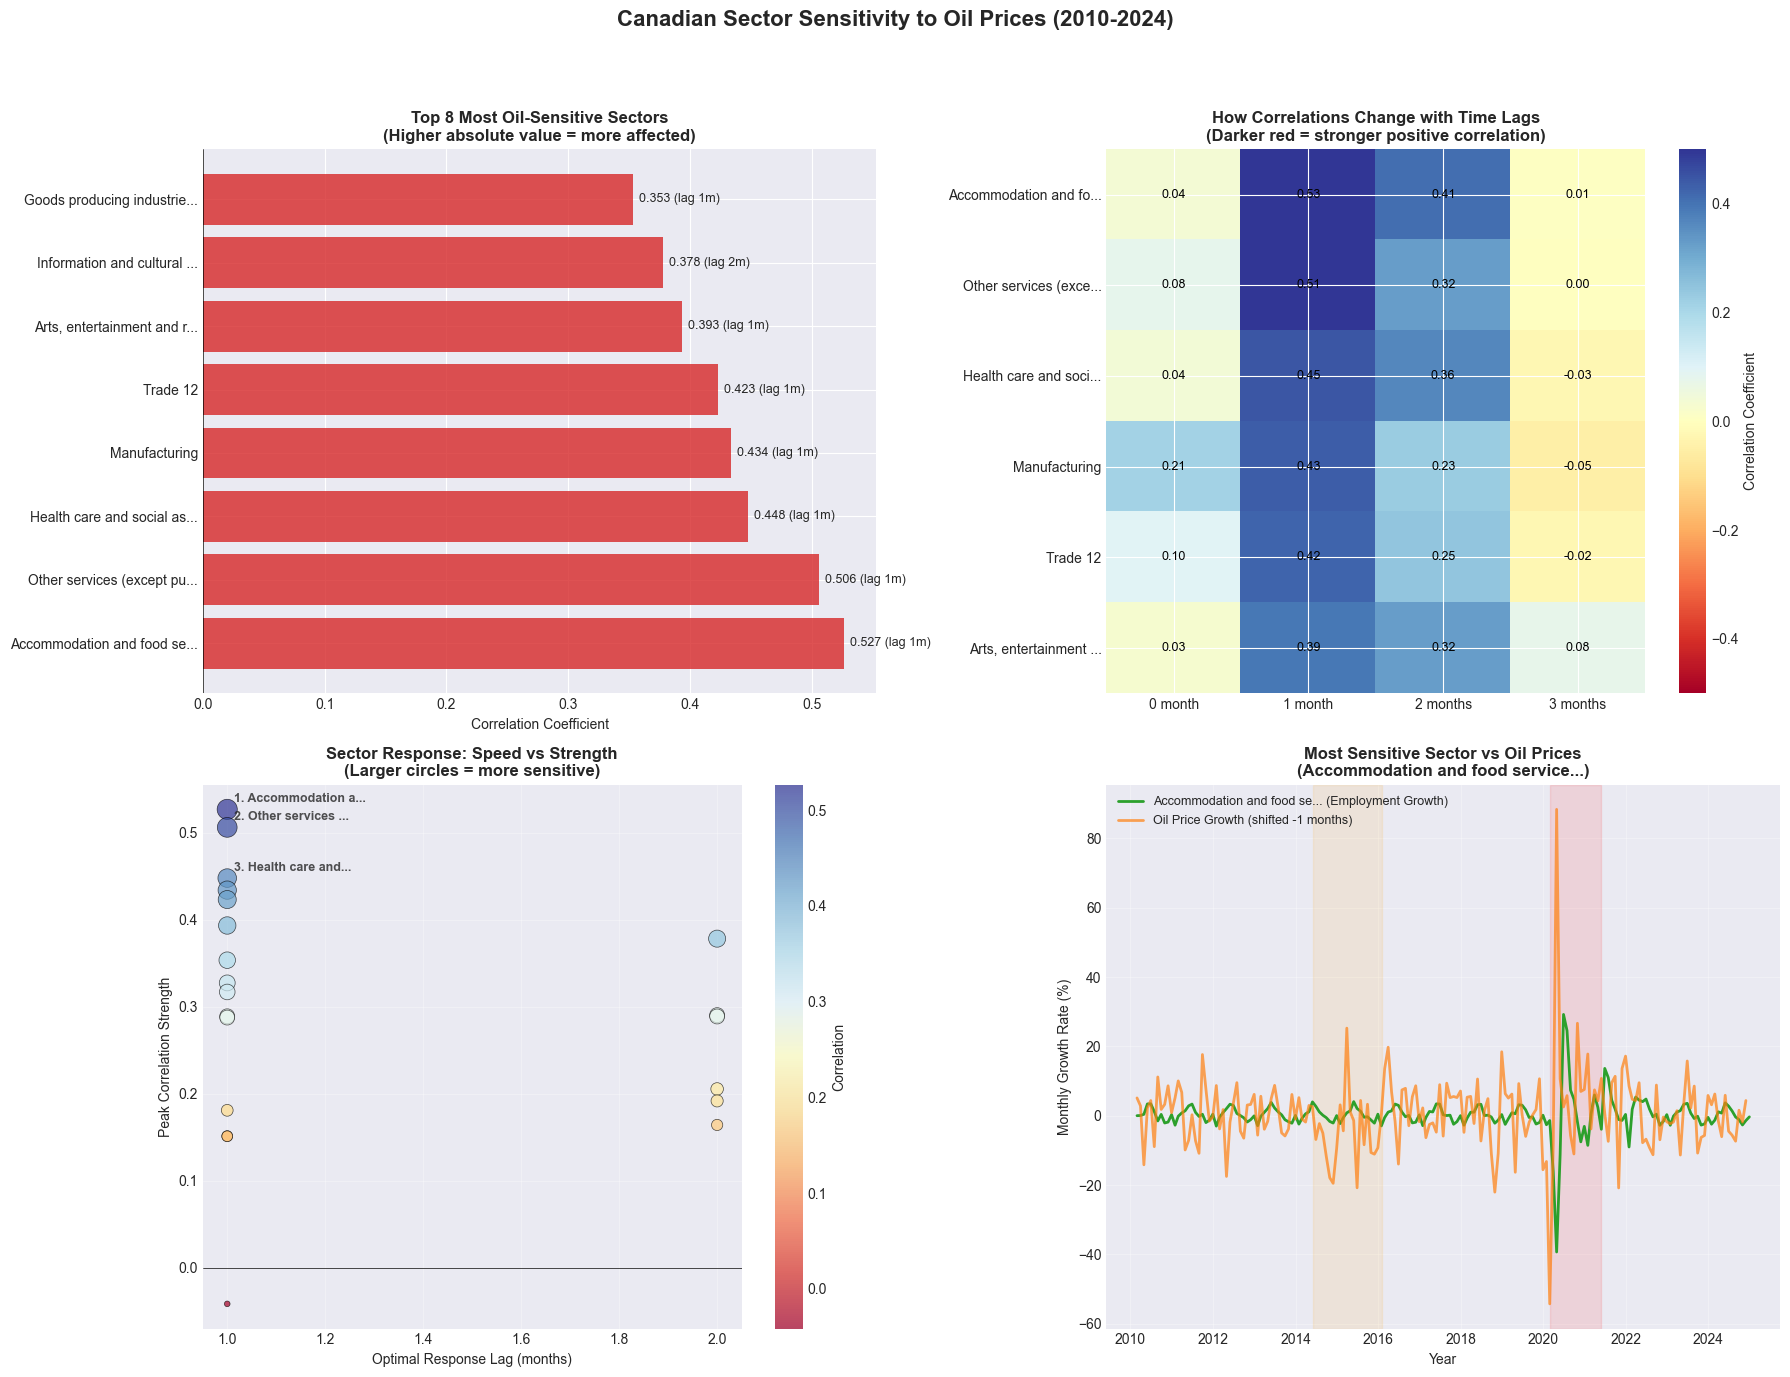


KEY INSIGHTS FROM VISUALIZATIONS
1. Accommodation and food services...
   → rises with oil prices (correlation: 0.527)
   → Reacts after 1 month(s)

2. Other services (except public administra...
   → rises with oil prices (correlation: 0.506)
   → Reacts after 1 month(s)

3. Health care and social assistance...
   → rises with oil prices (correlation: 0.448)
   → Reacts after 1 month(s)



In [10]:
# ============================================================================
# STEP 4: SINGLE-PAGE VISUALIZATION DASHBOARD
# ============================================================================

if 'results_df' in locals() and len(results_df) > 0:
    print("\n" + "="*70)
    print("CREATING SINGLE-PAGE VISUALIZATION DASHBOARD")
    print("="*70)
    
    # Create figure with 2x2 grid
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    
    # 1. TOP 8 MOST SENSITIVE SECTORS (Top-left)
    top_8 = results_df.head(8).copy()
    colors_1 = ['#d62728' if corr > 0 else '#1f77b4' for corr in top_8['Best Correlation']]
    
    bars = ax1.barh(range(len(top_8)), top_8['Best Correlation'], color=colors_1, alpha=0.8)
    ax1.set_yticks(range(len(top_8)))
    ax1.set_yticklabels([s[:25] + '...' if len(s) > 25 else s for s in top_8['Sector']])
    ax1.set_xlabel('Correlation Coefficient', fontsize=10)
    ax1.set_title('Top 8 Most Oil-Sensitive Sectors\n(Higher absolute value = more affected)', fontsize=12, fontweight='bold')
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    # Add correlation values
    for i, (_, row) in enumerate(top_8.iterrows()):
        value_text = f"{row['Best Correlation']:.3f} (lag {row['Best Lag']}m)"
        ax1.text(row['Best Correlation'] + (0.005 if row['Best Correlation'] > 0 else -0.04), 
                i, value_text, va='center', fontsize=9)
    
    # 2. LAGGED CORRELATION HEATMAP (Top-right)
    heatmap_sectors = results_df.head(6)['Sector'].tolist()
    heatmap_data = []
    
    for sector in heatmap_sectors:
        sector_row = results_df[results_df['Sector'] == sector].iloc[0]
        row_data = [
            sector_row['Correlation (0-month)'],
            sector_row['Correlation (1-month)'],
            sector_row['Correlation (2-month)'],
            sector_row['Correlation (3-month)']
        ]
        heatmap_data.append(row_data)
    
    heatmap_data = np.array(heatmap_data)
    
    im = ax2.imshow(heatmap_data, cmap='RdYlBu', aspect='auto', vmin=-0.5, vmax=0.5)
    
    ax2.set_xticks(range(4))
    ax2.set_xticklabels(['0 month', '1 month', '2 months', '3 months'])
    ax2.set_yticks(range(len(heatmap_sectors)))
    ax2.set_yticklabels([s[:20] + '...' if len(s) > 20 else s for s in heatmap_sectors])
    ax2.set_title('How Correlations Change with Time Lags\n(Darker red = stronger positive correlation)', 
                  fontsize=12, fontweight='bold')
    
    # Add correlation values
    for i in range(len(heatmap_sectors)):
        for j in range(4):
            ax2.text(j, i, f'{heatmap_data[i, j]:.2f}',
                    ha="center", va="center", color="black", fontsize=9)
    
    plt.colorbar(im, ax=ax2, label='Correlation Coefficient')
    
    # 3. SECTOR SENSITIVITY SCATTER PLOT (Bottom-left)
    sizes = results_df['Abs Correlation'] * 400
    
    scatter = ax3.scatter(results_df['Best Lag'], results_df['Best Correlation'], 
                         s=sizes, alpha=0.7, c=results_df['Best Correlation'], 
                         cmap='RdYlBu', edgecolors='black', linewidth=0.5)
    
    ax3.set_xlabel('Optimal Response Lag (months)', fontsize=10)
    ax3.set_ylabel('Peak Correlation Strength', fontsize=10)
    ax3.set_title('Sector Response: Speed vs Strength\n(Larger circles = more sensitive)', 
                  fontsize=12, fontweight='bold')
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax3.grid(True, alpha=0.3)
    
    # Label top 3 sectors
    for i in range(min(3, len(results_df))):
        row = results_df.iloc[i]
        ax3.annotate(f"{i+1}. {row['Sector'][:15]}...", 
                    (row['Best Lag'], row['Best Correlation']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, fontweight='bold', alpha=0.8)
    
    plt.colorbar(scatter, ax=ax3, label='Correlation')
    
    # 4. TIME SERIES COMPARISON (Bottom-right - Top 1 sector only)
    if 'combined_clean' in locals():
        top_sector = results_df.head(1)['Sector'].iloc[0]
        sector_growth_col = f"{top_sector}_growth"
        
        if sector_growth_col in combined_clean.columns:
            optimal_lag = results_df.head(1)['Best Lag'].iloc[0]
            
            # Plot both series
            ax4.plot(combined_clean.index, combined_clean[sector_growth_col], 
                    label=f'{top_sector[:25]}... (Employment Growth)', 
                    linewidth=2, color='#2ca02c')
            ax4.plot(combined_clean.index, combined_clean['oil_growth'].shift(-optimal_lag), 
                    label=f'Oil Price Growth (shifted -{optimal_lag} months)', 
                    linewidth=2, alpha=0.7, color='#ff7f0e')
            
            ax4.set_title(f'Most Sensitive Sector vs Oil Prices\n({top_sector[:30]}...)', 
                         fontsize=12, fontweight='bold')
            ax4.set_ylabel('Monthly Growth Rate (%)', fontsize=10)
            ax4.set_xlabel('Year', fontsize=10)
            ax4.legend(loc='upper left', fontsize=9)
            ax4.grid(True, alpha=0.3)
            
            # Highlight key events
            ax4.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2021-06-01'), 
                       alpha=0.1, color='red', label='COVID-19')
            ax4.axvspan(pd.Timestamp('2014-06-01'), pd.Timestamp('2016-02-01'), 
                       alpha=0.1, color='orange', label='2014-16 Oil Crash')
    
    # Add overall title
    plt.suptitle('Canadian Sector Sensitivity to Oil Prices (2010-2024)\n', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for suptitle
    
    # Save the dashboard
    os.makedirs('../outputs/plots', exist_ok=True)
    plt.savefig('../outputs/plots/sector_sensitivity_dashboard.png', dpi=300, bbox_inches='tight')
    print("✅ Created single-page dashboard: outputs/plots/sector_sensitivity_dashboard.png")
    
    plt.show()
    
    # Print key insights
    print("\n" + "="*70)
    print("KEY INSIGHTS FROM VISUALIZATIONS")
    print("="*70)
    
    top_3 = results_df.head(3)
    for i, (_, row) in enumerate(top_3.iterrows()):
        direction = "rises with" if row['Best Correlation'] > 0 else "falls with"
        print(f"{i+1}. {row['Sector'][:40]}...")
        print(f"   → {direction} oil prices (correlation: {row['Best Correlation']:.3f})")
        print(f"   → Reacts after {row['Best Lag']} month(s)")
        print()